In [1]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math
from scipy import stats
import random
from pyper import *
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from scipy import stats
from neurocombat_sklearn import CombatModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from random import random
import pickle

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


# 1. Generate Simulated Dataset

## 1.1 Generate dummy dataset
The function ***generate_dummy_dataset*** is used to generate handcrafted trivial dataset. It takes five paramaters:
1. **label_list**: a list of distinct labels, e.g. if there are three distinct classes then [1,2,3]
2. **n_samples_label**: a list of how many samples are there for each of the distinct classes. e.g. [20,10,5], 20 samples for class 1; 10 samples for class 2; 5 samples for class 3 etc.
3. **inform_mean_list**: a 2-d array of the mean values for each feature of each class. e.g. [[2,3,4,5],[6,7,8,9],[10,11,12,13]]. It indicates that there are four features in total. [2,3,4,5] is the mean value for each feature of class 1 around which the datapoint will be generated.
3. **inform_std_list**: a 1-d array of the standard deviation values for each feature column when generating the data points. e.g. [0.1, 0.2, 0.1, 0.1]. It indicates that the std value for generating feature 1 is 0.1 and etc.
4. **n_noise**: optional parameter, default value is None. When specified as a list: [number_of_noise_columns,(noise_range_lower, noise_range_higher)]. E.g. [1, (0, 100)] means that one column of noise data will be generated, it is generated within the range from 0 to 100.

In [2]:
def generate_dummy_dataset(label_list, n_samples_label, inform_mean_list, inform_std_list, n_noise=None):
    # check if the input parameters are correct
    n_features = len(inform_std_list)
    n_samples = sum(n_samples_labels)
    for i in range(len(inform_mean_list)):
        assert len(inform_mean_list[i]) == n_features
    
    assert len(label_list) == len(n_samples_labels)
    
    X,y = [],[]
    for i,v in enumerate(n_samples_labels):
        class_data = []
        for j in range(n_features):
            col = np.random.normal(inform_mean_list[i][j], inform_std_list[j], v).reshape(-1,1)
            class_data.append(col)
        class_labels = [label_list[i] for k in range(v)]
        class_data = np.concatenate(class_data, axis=1).reshape(v,n_features)
        X.append(class_data)
        y.append(class_labels)
        
    X = np.concatenate(X,axis=0)
    y = np.asarray([item for sublist in y for item in sublist])
    
    if n_noise is not None:
        n_noise_col = n_noise[0]
        noise_range = n_noise[1]
        noise_data = np.random.uniform(low=noise_range[0], high=noise_range[1], size=(n_samples,n_noise_col))
        X = np.concatenate((X, noise_data), axis=1)
        
    return X, y

The function ***swap*** is a helper function to shuffle a particular column of features among different classes. It takes three parameters:
1. X_base: this is the base data to be swapped
2. class_1_swap: this is the feature index from class_1
3. class_2_swap: this is the feature index from class_2
4. feature_index: this is the column index on which swap is performed

In [3]:
def swap(X_base, class_1_swap, class_2_swap, feature_index):
    X_temp = X_base.copy()
    for i in range(len(class_1_swap)):
        temp = X_temp[class_1_swap[i]][feature_index]
        X_temp[class_1_swap[i]][feature_index] = X_temp[class_2_swap[i]][feature_index]
        X_temp[class_2_swap[i]][feature_index] = temp
    return X_temp

def swap_multiple(X_base,feature_index,class_1_swap,class_2_swap,class_3_swap):
    X_temp = np.copy(X_base)
    for i in range(len(class_1_swap)):
        if i<3:
            temp_1 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_2_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = temp_2
            
        elif i>=3 and i<6:
            temp_3 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_2_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = temp_2
            
        elif i>=6 and i<9:
            temp_1 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_2
        else:
            temp_1 = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_2_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_1
        
            temp_2 = X_temp[class_3_swap[i]][feature_index]
            X_temp[class_3_swap[i]][feature_index] = X_temp[class_1_swap[i]][feature_index]
            X_temp[class_1_swap[i]][feature_index] = temp_2
    return X_temp

In [4]:
def add_redundant(X,index,slope,intercept):
    X_temp = X.copy()
    redundant_col = X_temp[:,index] * slope + intercept
    X_with_redundant = np.concatenate((X_temp, redundant_col.reshape(-1,1)),axis=1)
    return X_with_redundant

def add_noise(X, low, high, size):
    X_temp = X.copy()
    noise_data = np.random.uniform(low=low, high=high, size=(X_temp.shape[0],size))
    X_with_noise = np.concatenate((X_temp, noise_data), axis=1)
    return X_with_noise

def generate_redundant(X,index,slope,intercept):
    X_temp = X.copy()
    redundant_col = X_temp[:,index] * slope + intercept
#     X_with_redundant = np.concatenate((X_temp, redundant_col.reshape(-1,1)),axis=1)
    return redundant_col

def generate_noise(X, low, high, size):
    X_temp = X.copy()
    noise_data = np.random.uniform(low=low, high=high, size=(X_temp.shape[0],size))
#     X_with_noise = np.concatenate((X_temp, noise_data), axis=1)
    return noise_data

# 1.1.1 Example

This demonstrate the data generated by the above mentioned function. The following parameters are specified:
1. label_list = [1,2]
2. n_samples_labels = [20,20]
3. inform_mean_list = [[2,5,7,9],[9,1,2,6]]
4. inform_std_list = [0.001, 0.001, 0.001, 0.001]
5. n_noise = [1,(-100,100)]

In [5]:
label_list = [1,2]
n_samples_labels = [20,20]
inform_mean_list = [[2,5,7,9],[9,1,2,6]]
inform_std_list = [0.001, 0.001, 0.001, 0.001]
n_noise = [1,(-100,100)]

X_example, y_example = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list, n_noise)
print("X_example: \n", X_example)
print("y_example: \n", y_example)

class_1_index = [2, 4, 6, 8, 10]
class_2_index = [21, 23, 25, 27, 29]

X_swapped = swap(X_example, class_1_index, class_2_index, 0)
print("X_swapped: \n", X_swapped)

X_example: 
 [[  2.00128833   5.00081642   7.00183362   8.99952304 -21.56062775]
 [  1.99934873   5.00013061   7.0017547    9.00075111 -18.3834819 ]
 [  2.00034154   4.9999651    7.00044265   8.99872978  91.37877736]
 [  1.99870924   4.99977365   7.00023551   8.99997127  70.2320918 ]
 [  1.99987972   5.00067072   6.99993684   9.00001664 -15.53732155]
 [  1.99933808   5.00033252   6.99987049   9.00129298  89.33914921]
 [  1.99893209   5.00065437   7.00042922   8.99923028  76.05680986]
 [  2.00112139   5.00072398   6.99938305   9.00033155  42.49594561]
 [  2.00004252   5.0024049    7.00064832   9.00029967 -90.49159731]
 [  1.99953349   5.00159622   6.99893091   9.00061339  56.41377567]
 [  2.00140155   5.00061077   7.00120717   8.99850248  60.11501377]
 [  2.00093762   5.00134298   6.99970806   9.00131916   6.95379186]
 [  2.0003188    5.00112825   6.99931594   8.9991015   -8.08114698]
 [  2.0005075    5.0004954    7.00106619   9.00091928  -1.77295999]
 [  1.99991952   4.99980462   6.999

# 2. Helper Functions for Data Visualization

## 2.1 Compute the Mutual Information Matrix of the features

In [5]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def featureTargetRelevance(X, y, n_informative):
    feature_scores = mutual_info_regression(X, y, random_state=0)
    fig,ax = plt.figure(figsize = (10, 5)) 
    sort_value = sorted(feature_scores, reverse=True)
    sort_index = np.argsort(-1*feature_scores)
    column = np.asarray([i for i in range(0,n_total)])
    # plt.bar(column, sort_value, color ='maroon')
    # creating the bar plot 
    for i,v in enumerate(sort_index):
        if i < n_informative:
            plt.bar(column[i], sort_value[i], color ='maroon')
        else:
            plt.bar(column[i], sort_value[i], color ='blue')
    plt.xticks(column, sort_index)
    plt.xlabel("Feature Index") 
    plt.ylabel("Mutual Information Score with target") 
    plt.title("Mutual Information Score") 
    plt.show() 
    
def computeMIMatrix(X_mrmr, index):
    n_features = X_mrmr.shape[1]
    array = np.zeros(n_features * n_features)
    array = array.reshape(n_features, n_features)
    labels = []
    for i in range(n_features):
        tmp = []
        for j in range(n_features):
            # print("i: {}; j:{}".format(i,j))
            mutual_info = mutual_info_regression(X_mrmr[:,i].reshape(-1,1), X_mrmr[:,j])
            array[i][j] = mutual_info
            tmp.append("({},{}) \n {}".format(i,j, round(mutual_info[0], 7)))
            # print(mutual_info)
        labels.append(tmp)
    fig,ax = plt.subplots(figsize=(15,10))
    title = "Mutual Information between pairwise features"
    sns.heatmap(array, annot=labels,fmt="",cmap="Blues", linewidth=0.3, ax=ax)
    plt.show()
    plt.savefig('computed_mim_' + str(index) + '.png')
    return array, labels

def visualize_clusters(X,y,index):
    pca = PCA(n_components=2).fit(X)
    pca_2d = pca.transform(X)
    fig,ax = plt.subplots(figsize=(10,5))
    plt.scatter(pca_2d[:,0],pca_2d[:,1], c=y, alpha=0.5)
    plt.title("ground truth")
    plt.xlabel('x')
    plt.ylabel('y')
#     plt.savefig('class_sep_' + str(index) + '.png')

# 3. Test Feature Reduction Step
## 3.1 Feature Reduction Step Implementation

In [6]:
def t_test(X, y):
    
    def separate(X, y):
        # Y is the classes (1=stable, 2=progressor)
        P_X, S_X = [], []
        for i in range(X.shape[0]):
            if  y[i] == 0:
                S_X.append(X[i])
            elif y[i] == 1:
                P_X.append(X[i])
        return np.asarray(P_X), np.asarray(S_X)

    def t_test(P, S, y):
        t_vals = []
        for i in range(P.shape[1]):
            t_score, p_val = stats.ttest_ind(P[:,i], S[:,i])
            tuple_ = (abs(t_score), abs(p_val))
            t_vals.append((tuple_, i))
        return t_vals

    def select(X, y, t_vals, percentage=.5):
        total_nfeatures = X.shape[1]
        filtered_nfeatures = math.ceil(total_nfeatures*percentage)
        print("total_nfeatures: ",total_nfeatures)
        print("filtered_nfeatures", filtered_nfeatures)
        sorted_t_val = sorted(t_vals, key=lambda tup: tup[0][0], reverse=True)
        print(sorted_t_val)
        selected_indices = [i[1] for i in sorted_t_val[:filtered_nfeatures]]
        sorted_selected_indices = sorted(selected_indices)
        X_reduced = X[:,sorted_selected_indices]
        return X_reduced, sorted_selected_indices
    
    P_X, S_X = separate(X, y)
    t_vals = t_test(P_X, S_X, y)
    X_reduced, selected_indices = select(X, y, t_vals)
    return X_reduced, selected_indices

## 3.2 Feature Reduction Step Validation

### 3.2.1 Load Current Simulated Dataset

In [9]:
X_ttest = np.genfromtxt("./datasets/ttest_simulated_data.csv", delimiter=',')
X_ttest_base = X_ttest[:,:-1]
y_ttest_base = X_ttest[:,-1]
print("X_ttest_base:\n", X_ttest_base)
print("X_ttest_base.shape:", X_ttest_base.shape)
print("y_ttest_base:\n", y_ttest_base)
print("y_ttest_base.shape:", y_ttest_base.shape)

X_ttest_base:
 [[ 1.99987861  9.00009529  6.999879   ... 68.47663344 67.38421027
  30.717765  ]
 [ 2.00018866  9.00008163  6.99994704 ... 72.42864757 35.20120916
  43.48937762]
 [ 1.999791    8.99993024  6.99988622 ... 76.11559446 44.29928999
   9.33903386]
 ...
 [ 8.99996795  1.00016002  1.99992334 ... 63.20839764 18.06747326
  53.77168036]
 [ 9.00009527  0.99996585  1.99987161 ... 57.17926085 32.65607412
  90.83715886]
 [ 9.00003086  1.0000186   2.00003513 ... 88.00478944  5.50215028
  31.2981323 ]]
X_ttest_base.shape: (300, 7)
y_ttest_base:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

### 3.2.2 Create Simulated Dataset

In [ ]:
# create a simulated dataset
label_list = [0,1]
n_samples_labels = [150,150]
inform_mean_list = [[2,9,7,2],[9,1,2,6]]
inform_std_list = [0.0001, 0.0001, 0.0001, 0.0001]
n_noise = [3,(0,100)]

X_ttest_base, y_ttest_base = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list, n_noise)
print("X_ttest_base: \n", X_ttest_base)
print("y_ttest_base: \n", y_ttest_base)

In [10]:
X_after_test, columns_ttest = t_test(X_ttest_base, y_ttest_base)
print("columns_ttest: ", columns_ttest)

total_nfeatures:  7
filtered_nfeatures 4
[((689828.4999486395, 0.0), 1), ((565851.2043635682, 0.0), 0), ((439769.20209753356, 0.0), 2), ((354152.15786922106, 0.0), 3), ((0.6272164339246519, 0.5309976306642527), 4), ((0.284414459789654, 0.7762903111766724), 6), ((0.170409533484432, 0.8648037122514078), 5)]
columns_ttest:  [0, 1, 2, 3]


## 3.3 Save T-test Dataset

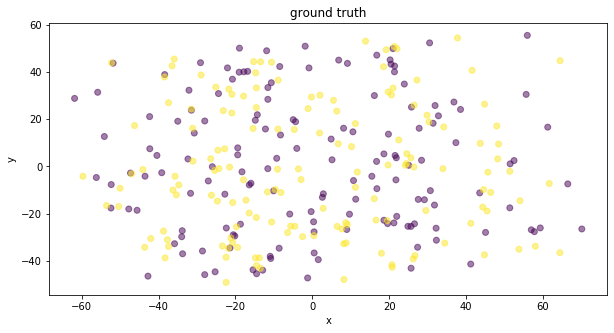

In [11]:
visualize_clusters(X_ttest_base, y_ttest_base, 0)

In [10]:
ttest_data = np.concatenate((X_ttest_base,y_ttest_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/ttest_simulated_data.csv",ttest_data , delimiter=",")

# 4. Test Subtype Clustering Step
## 4.1 Subtype Clustering Step Implementation

In [12]:
from snf import compute

class Clustering():

    def __init__(self, debug_mode=False):
        """Apply fit_transform on the training data

            Arguments
            ---------
                debug_mode: boolean
                    If true, intermediate results will be printed for debugging purposes 
                    at the end of each function call.
        """
        self.debug_mode = debug_mode
        pass

    # setter for number of subclusters for P
    def setNumP(self, numP):
        self.numP = numP

    # setter for number of subclusters for S
    def setNumS(self, numS):
        self.numS = numS

    # Step1. Separate out P and S
    def separate(self, X, y):
        """Separate out the progressor and stable instances to be used for clustering later. 

            As the data in is reindexed by the stratifiedKfold. It is important for us
            to save the indexes of the rows before we separate them out and do clustering 
            accordingly. In this function, while the data is splitted into separate lists 
            by class, the original index for each row is saved. After the clustering is done, 
            we will reindex our combined data set according to the saved indexes.

            Arguments
            ---------
                X: numpy.ndarray
                    The combined data
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                P_X: list
                    Progressor data
                P_y: list
                    Progressor data labels
                S_X: list
                    Stable data
                S_y: list
                    Stable data labels     
        """

        # initialize empty lists to store index of P&S instances in the
        # original data
        index_P, index_S = [], []

        # initialize lists to store the separated P and S instances
        P_X, P_y, S_X, S_y = [], [], [], []
        # store P and S instances separately and keep track of the indexes in
        # the original data

        for i in range(0, y.shape[0]):
            if y[i] == 1:
                S_X.append(X[i])
                S_y.append(y[i])
                index_S.append(i)
            else:
                P_X.append(X[i])
                P_y.append(y[i])
                index_P.append(i)

        # store the indexes as a global attribute for the clasds
        self.index_P = index_P
        self.index_S = index_S

        # print all the computed matrxi if debug mode is enabled
        if self.debug_mode == True:
            print("index_P", self.index_P)
            print("index_S", self.index_S)

#         print("P_X separate", P_X)
        return np.asarray(P_X), np.asarray(P_y), np.asarray(S_X), np.asarray(S_y)

    def clusteringP(self, P_X):
        """Apply Spectral Clustering on Progressor data.

            SpectralClustering is performed on P class instances. The number of clusters 
            is specified by the global attribute num_P. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                P_X: list
                    The progressor data.
            Returns
            -------
                P_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """
        affinity_networks = compute.make_affinity(P_X, metric='euclidean', K=self.numP, mu=0.5)
        
        clusteringP = SpectralClustering(affinity='precomputed',
            n_clusters=self.numP, random_state=0).fit(affinity_networks)
        
        labels = clusteringP.labels_.reshape(-1, 1)
        P_X = np.asarray(P_X)
        P_X_clustered = np.concatenate((P_X, labels), axis=1)

        if self.debug_mode == True:
            print("P labels", np.reshape(labels, (1, -1)))
            print("P_X_clustered", P_X_clustered)

        return P_X_clustered

    def clusteringS(self, S_X):
        """Apply Spectral Clustering on Stable data.

            SpectralClustering is performed on the S class instances. The number of clusters 
            is specified by the global attribute num_S. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                S_X: list
                    The progressor data.
            Returns
            -------
                S_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """

        affinity_networks = compute.make_affinity(S_X, metric='euclidean', K=self.numS, mu=0.5)
        
        clusteringS = SpectralClustering(affinity='precomputed',
            n_clusters=self.numS, random_state=0).fit(affinity_networks)

        labels = clusteringS.labels_
        labels = labels + self.numP
        S_X = np.asarray(S_X)
        labels = labels.reshape(-1, 1)
        S_X_clustered = np.concatenate((S_X, labels), axis=1)

        if self.debug_mode == True:
            print("S labels", np.reshape(labels, (1, -1)))
            print("S_X_clustered", S_X_clustered)

        return S_X_clustered

    def transform(self, X, y):
        """Apply Spectral Clustering on stable data and progressor data. 
            Step 1. Separate data out into P and S classes. Save the original data index as 
            the data rows will be reindexed for clustering. 
            Step 2. Perform clustering for P class based on num_P. Attach the new labels.
            Step 3. Perform clustering for S class based on num_S. Attach the new labels. 
            Step 4. Combine the newly clustered P class data and S class data. Reindex the 
            data rows according to the saved indexes. 
            Arguments
            ---------
                X: numpy.ndarray
                    The combined data of both P and S instances.
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                X_output: numpy.ndarray
                    The combined data with newly clustered labels attached.
        """

        P_X, P_y, S_X, S_y = self.separate(X, y)

        P_X_clustered = self.clusteringP(P_X)
        S_X_clustered = self.clusteringS(S_X)

        P_X_clustered_with_index = np.concatenate(
            (P_X_clustered, (np.array(self.index_P)).reshape(-1, 1)), axis=1)
        S_X_clustered_with_index = np.concatenate(
            (S_X_clustered, (np.array(self.index_S)).reshape(-1, 1)), axis=1)

        X_combined_with_index = np.concatenate(
            (P_X_clustered_with_index, S_X_clustered_with_index), axis=0)

        X_sorted = X_combined_with_index[
            np.argsort(X_combined_with_index[:, -1])]
        new_labels = X_sorted[:,-2]
        X_output = X_sorted[:, :-2]

        if self.debug_mode == True:
            print("P_X_clustered_with_index", P_X_clustered_with_index)
            print("S_X_clustered_with_index", S_X_clustered_with_index)
            print("X_sorted", X_sorted)
            print("X_output", X_output)
            print("X_output.labels", X_output[:, -1])

        return X_output, new_labels

## 4.2 Subtype Clustering Step Validation

### 4.2.1 Load Current Simulated Dataset

In [13]:
X_clustering_combined = np.genfromtxt("./datasets/clustering_simulated_data.csv", delimiter=',')
X_clustering = X_clustering_combined[:,:-1]
y_clustering = X_clustering_combined[:,-1]
print("X_clustering:\n", X_clustering)
print("X_clustering.shape:", X_clustering.shape)
print("y_clustering:\n", y_clustering)
print("y_clustering.shape:", y_clustering.shape)

X_clustering:
 [[ 1.99993607  8.99988309  7.0000718   1.99997781 10.83866922]
 [ 1.99982525  8.9999829   6.99986095  2.0000373   8.53631131]
 [ 1.99998189  9.00007723  6.99991209  1.99985021 70.81452422]
 ...
 [ 5.00000503  9.00001764  0.99989893  3.99990279 81.49890237]
 [ 4.99999383  8.99998789  1.00008012  4.00020877 96.99674997]
 [ 4.99986991  8.99986544  0.99989916  3.9999219  98.26687812]]
X_clustering.shape: (300, 5)
y_clustering:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

### 4.2.2 Create Simulated Dataset

In [12]:
# Generate the base dataset
label_list = [0,1,2]
n_samples_labels = [100,100,100]
inform_mean_list = [[2,9,7,2],[9,1,2,6],[5,9,1,4]]
inform_std_list = [0.0001, 0.0001, 0.0001, 0.0001]
n_noise = [1,(0,100)]

n_clusters = len(n_samples_labels)

X_clustering, y_clustering = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list, n_noise)
print("X_ttest_base: \n", X_clustering)
print("y_ttest_base: \n", y_clustering)

X_ttest_base: 
 [[ 1.99993607  8.99988309  7.0000718   1.99997781 10.83866922]
 [ 1.99982525  8.9999829   6.99986095  2.0000373   8.53631131]
 [ 1.99998189  9.00007723  6.99991209  1.99985021 70.81452422]
 ...
 [ 5.00000503  9.00001764  0.99989893  3.99990279 81.49890237]
 [ 4.99999383  8.99998789  1.00008012  4.00020877 96.99674997]
 [ 4.99986991  8.99986544  0.99989916  3.9999219  98.26687812]]
y_ttest_base: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

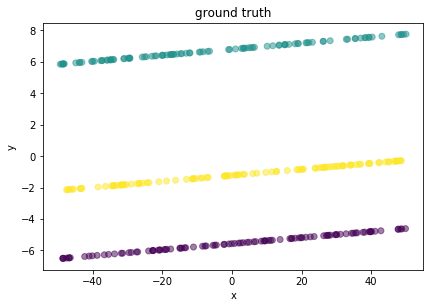

Ground Truth Label: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


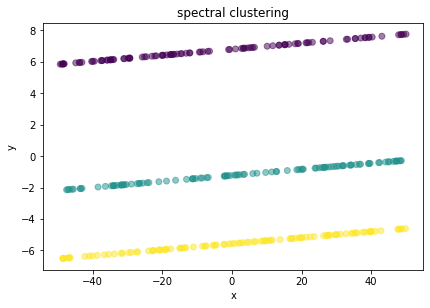

Labels returned by Subtype Clustering Step: 
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2).fit(X_clustering)
pca_2d = pca.transform(X_clustering)

################################ ground truth with PCA ################################
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c=y_clustering, alpha=0.5)
plt.title("ground truth")
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print("Ground Truth Label: \n", y_clustering)

################################ spectral clustering ################################
clustering = Clustering()
clustering.setNumP(n_clusters)
clustered = clustering.clusteringP(X_clustering)
clustered_label = clustered[:,-1]

plt.figure(figsize=(15,10))
plt.subplot(222)
plt.title("spectral clustering")
plt.scatter(pca_2d[:,0],pca_2d[:,1], c=clustered_label, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("Labels returned by Subtype Clustering Step: \n", clustered_label)

## 4.3 Save Clustering Dataset 

In [14]:
ttest_data = np.concatenate((X_clustering,y_clustering.reshape(-1,1)), axis=1)
np.savetxt("./datasets/clustering_simulated_data.csv",ttest_data , delimiter=",")

# 5. Feature Selection Step (MRMR)
## 5.1 Feature Selection Step Implementation

In [14]:
def mrmrSelection(dataframe, nFeature):
    """Perform MRMR on the passed in data. 

        This function performs feature selection based on the mRMRe feature selection. 
        It utilizes the mRMRe package originally written in R. A python wrapper for R is
        used here. The eMRMRe returns a list of the selected column indices given the 
        number of features to be selected. 

        Arguments
        ---------
            dataframe: pandas.DataFrame
                The dataframe containing clustered data. 
        Returns
        -------
            df_: pandas.DataFrame
                The dataframe with only selected columns.
            labels: pandas.DataFrame
                The dataframe of only the labels
            colum_indices: list
                The list of indices of the selected columns
    """ 
    base = importr('base')
    mr = importr('mRMRe')
    pandas2ri.activate()
    # Convert the data into R format
    with localconverter(ro.default_converter + pandas2ri.converter):
        rdataframe = ro.conversion.py2rpy(dataframe)
    mrmrData = mr.mRMR_data(data = (rdataframe))
    solutionCount = 1
    selectionEnsemble = mr.mRMR_ensemble("mRMRe.Data",data = mrmrData, target_indices = (dataframe.shape[1]),
          feature_count = nFeature, solution_count = solutionCount)
    colum_indices =(mr.solutions(selectionEnsemble)[0]-1)
    mutual_information_matrix = mr.mim(mrmrData)
    df_ = pd.DataFrame()
    for i,v in enumerate(colum_indices):
        df_[i] = dataframe[v[0]]
    labels = dataframe.iloc[:,-1]
    colum_indices = list(np.reshape(colum_indices,(1,-1))[0])
    return df_, labels, colum_indices, mutual_information_matrix

## 5.2 Feature Selection Step Validation
### 5.2.1 Load Current Simulated Dataset

In [15]:
X_mrmr_combined = np.genfromtxt("./datasets/mrmr_base_simulated_data.csv", delimiter=',')
X_mrmr_base = X_mrmr_combined[:,:-1]
y_mrmr_base = X_mrmr_combined[:,-1]
print("X_mrmr_base:\n", X_mrmr_base)
print("X_mrmr_base.shape:", X_mrmr_base.shape)
print("y_mrmr_base:\n", y_mrmr_base)
print("y_mrmr_base.shape:", y_mrmr_base.shape)

X_mrmr_base:
 [[1.00009531 2.00000139 3.00021737 3.99987166 4.99997622]
 [0.99997544 1.99997624 2.99991967 4.00009469 4.99990906]
 [0.99987749 2.0000039  3.00021725 3.99987151 5.00011318]
 ...
 [8.99999613 5.00006471 1.99997715 4.00009269 2.99996137]
 [8.99999939 4.99996357 1.99985969 4.00009599 3.0000611 ]
 [9.00014158 5.00006495 2.00001502 3.99993462 3.00000567]]
X_mrmr_base.shape: (300, 5)
y_mrmr_base:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.

### 5.2.2 Create Simulated Dataset

In [104]:
# Generate the base dataset
label_list = [0,1,2]
n_samples_labels = [100,100,100]
inform_mean_list = [[1,2,3,4,5],[5,4,3,2,1],[9,5,2,4,3]]
inform_std_list = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]

n_clusters = len(n_samples_labels)

X_mrmr_base, y_mrmr_base = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list)
print("X_mrmr_base: \n", X_mrmr_base)
print("y_mrmr_base: \n", y_mrmr_base)

reduandant_col_1 = generate_redundant(X_mrmr_base,1, 2.5, 0.4)
print("reduandant_col_1: \n", reduandant_col_1)

reduandant_col_2 = generate_redundant(X_mrmr_base,2, 1.1, 0.8)
print("reduandant_col_2: \n", reduandant_col_2)

noise_col_1 = generate_noise(X_mrmr_base, -10, 10, 2)
print("noise_col_1: \n", noise_col_1)

noise_col_2 = [i % 100 for i in range(300)]
print(noise_col_2)

X_mrmr_base: 
 [[1.00009531 2.00000139 3.00021737 3.99987166 4.99997622]
 [0.99997544 1.99997624 2.99991967 4.00009469 4.99990906]
 [0.99987749 2.0000039  3.00021725 3.99987151 5.00011318]
 ...
 [8.99999613 5.00006471 1.99997715 4.00009269 2.99996137]
 [8.99999939 4.99996357 1.99985969 4.00009599 3.0000611 ]
 [9.00014158 5.00006495 2.00001502 3.99993462 3.00000567]]
y_mrmr_base: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]
reduan

In [118]:
noise_col_3 = [1 for i in range(300)]
print(noise_col_3)

noise_col_4 = [2 for i in range(300)]
print(noise_col_4)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### 5.2.3 Save MRMR Base Dataset

In [122]:
mrmr_base = np.concatenate((X_mrmr_base,y_mrmr_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/mrmr_base_simulated_data.csv",mrmr_base , delimiter=",")

### 5.3.2 Base Dataset + Swap Data Point

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 1, 2, 4]


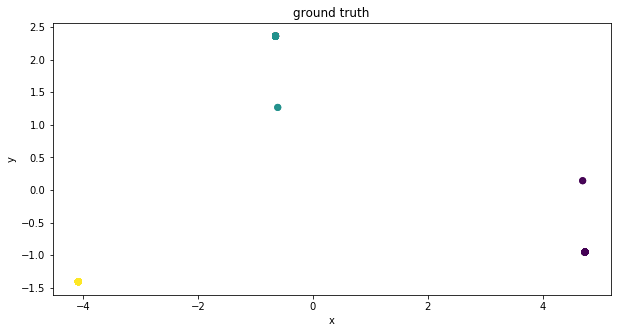

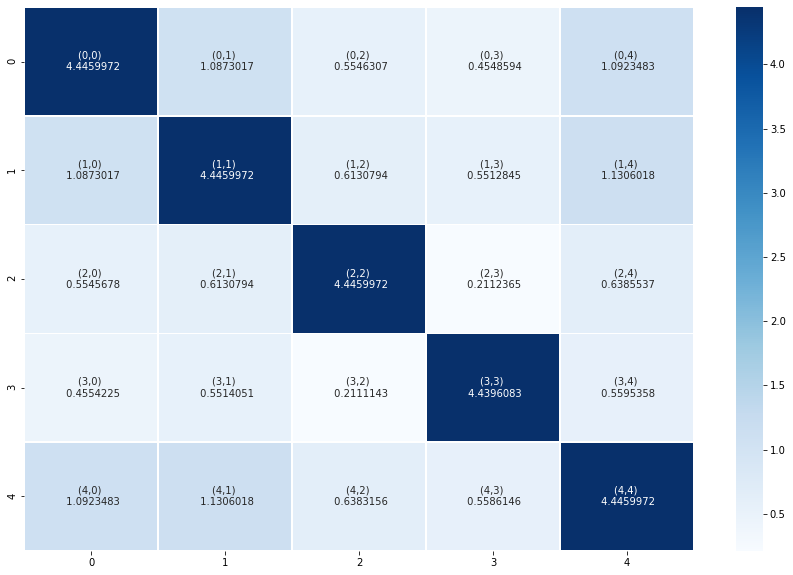

<Figure size 432x288 with 0 Axes>

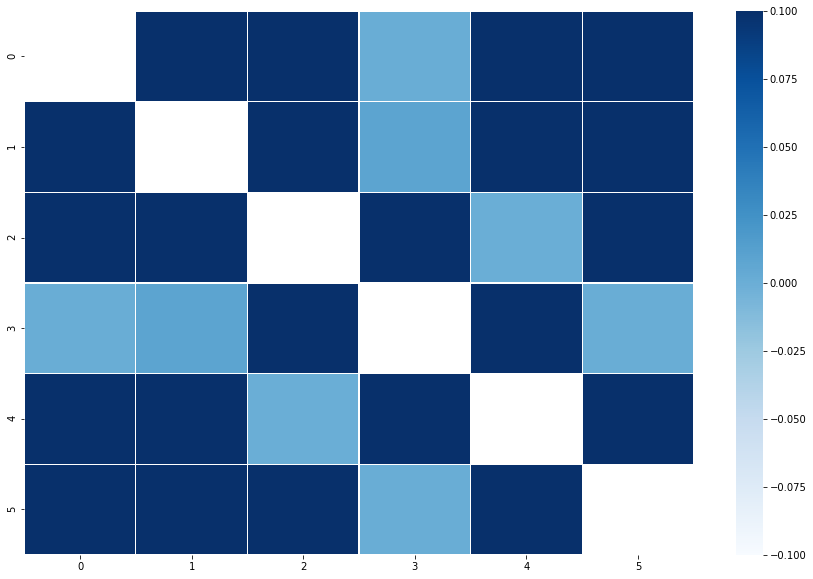

In [189]:
class_1_swap = [0, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21 , 23, 25, 27, 29] 
class_2_swap = [41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61 , 63, 65, 67, 69]
class_3_swap = [81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101 , 103, 105, 107, 109] 

X_mrmr_base_swap = swap_multiple(X_mrmr_base,3,class_1_swap,class_2_swap,class_3_swap)
# print("X_mrmr_base_swap: \n", X_mrmr_base_swap)

fig_num = 1
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_swap, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 4)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_swap, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_swap, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'
# plt.savefig(path)

### 5.2.2.1 Save MRMR Base Swap Features Dataset

In [123]:
mrmr_base_swap = np.concatenate((X_mrmr_base_swap,y_mrmr_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/mrmr_base_swap_simulated_data.csv",mrmr_base_swap , delimiter=",")

### 5.2.2 Base Dataset + Redundant

In [188]:
X_mrmr_read = np.genfromtxt("./datasets/mrmr_base_simulated_data.csv", delimiter=',')
X_mrmr_base = X_mrmr_read[:,:5]
y_mrmr_base = X_mrmr_read[:,-1]
reduandant_col_1 = generate_redundant(X_mrmr_base,1, 2.5, 0.4)
print("reduandant_col_1: \n", reduandant_col_1)
print(X_mrmr_base)
print(y_mrmr_base)

reduandant_col_1: 
 [ 5.40000347  5.3999406   5.40000974  5.39981003  5.39995084  5.39969374
  5.40000228  5.40002837  5.40005648  5.39963965  5.4005031   5.40029705
  5.40015953  5.39990681  5.39978692  5.40026982  5.40009431  5.39982581
  5.39999912  5.39998176  5.39992596  5.4004345   5.39980377  5.40021996
  5.39978005  5.39973853  5.40044776  5.3998849   5.39987035  5.4000643
  5.39983894  5.40002158  5.40001429  5.39999017  5.4005786   5.40023136
  5.40023254  5.39961253  5.39951769  5.39989946  5.40009546  5.40021289
  5.40023146  5.40011557  5.39995692  5.3995663   5.39994913  5.39983799
  5.39962556  5.40022095  5.40011179  5.40028294  5.40010409  5.3995821
  5.40019891  5.39996568  5.40023447  5.39999216  5.39996503  5.39983155
  5.40013691  5.40007428  5.39996696  5.40002903  5.40020044  5.39954305
  5.4002314   5.40010557  5.40017892  5.40009866  5.39975374  5.39997148
  5.40016792  5.39997043  5.39970286  5.40021518  5.40000595  5.39988766
  5.40016468  5.4001668   5.39994

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 1, 2, 4, 3]


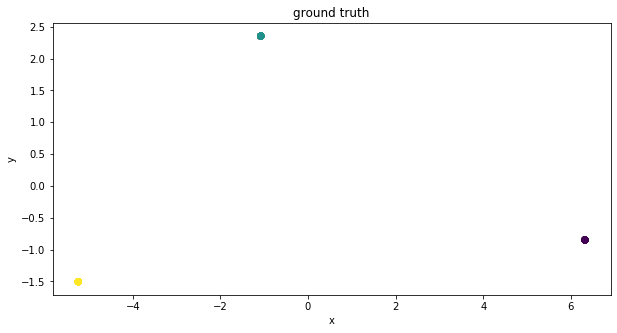

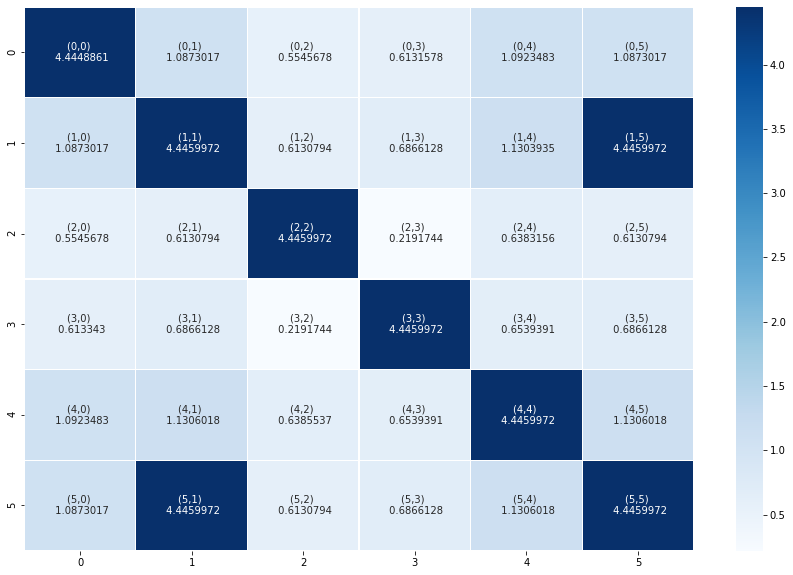

<Figure size 432x288 with 0 Axes>

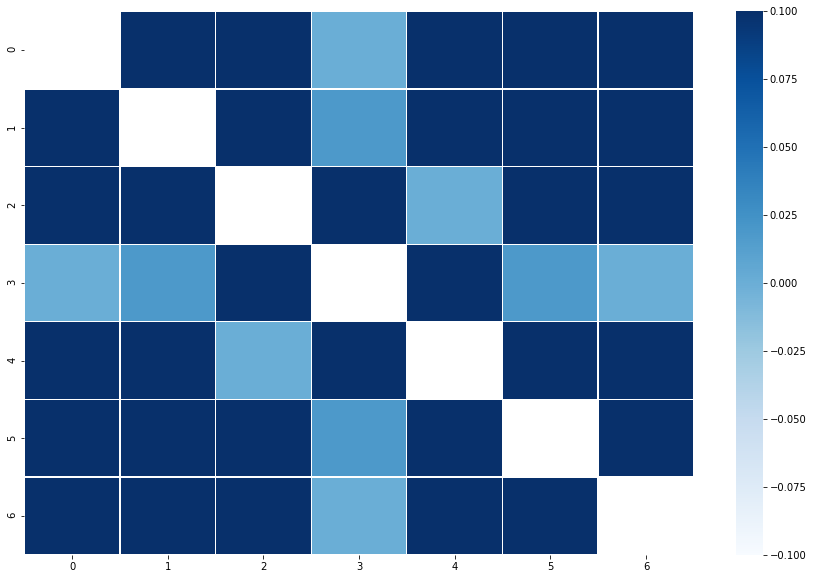

In [180]:
X_mrmr_base_redundant = np.concatenate((X_mrmr_base, np.asarray(reduandant_col_1).reshape(-1,1)), axis=1)

fig_num = 1
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_redundant, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 5)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_redundant, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_redundant, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'

### 5.2.2.1 Save MRMR Base Redundant Dataset

In [181]:
mrmr_base_swap = np.concatenate((X_mrmr_base_redundant,y_mrmr_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/mrmr_base_redundant_simulated_data.csv",mrmr_base_swap , delimiter=",")

### 5.2.3 Base Dataset + Noise

[[1.00009531 2.00000139 3.00021737 3.99987166 4.99997622 1.        ]
 [0.99997544 1.99997624 2.99991967 4.00009469 4.99990906 1.        ]
 [0.99987749 2.0000039  3.00021725 3.99987151 5.00011318 1.        ]
 ...
 [8.99999613 5.00006471 1.99997715 4.00009269 2.99996137 1.        ]
 [8.99999939 4.99996357 1.99985969 4.00009599 3.0000611  1.        ]
 [9.00014158 5.00006495 2.00001502 3.99993462 3.00000567 1.        ]]


/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 1, 2, 4, 3]


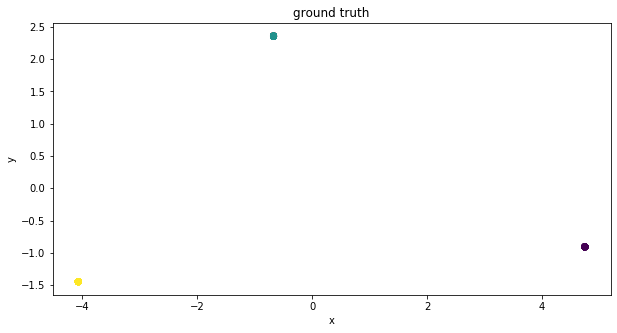

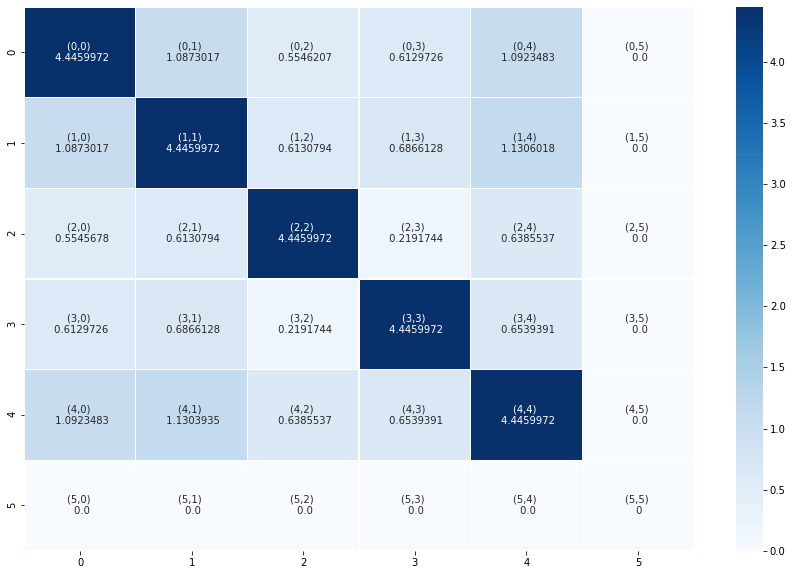

<Figure size 432x288 with 0 Axes>

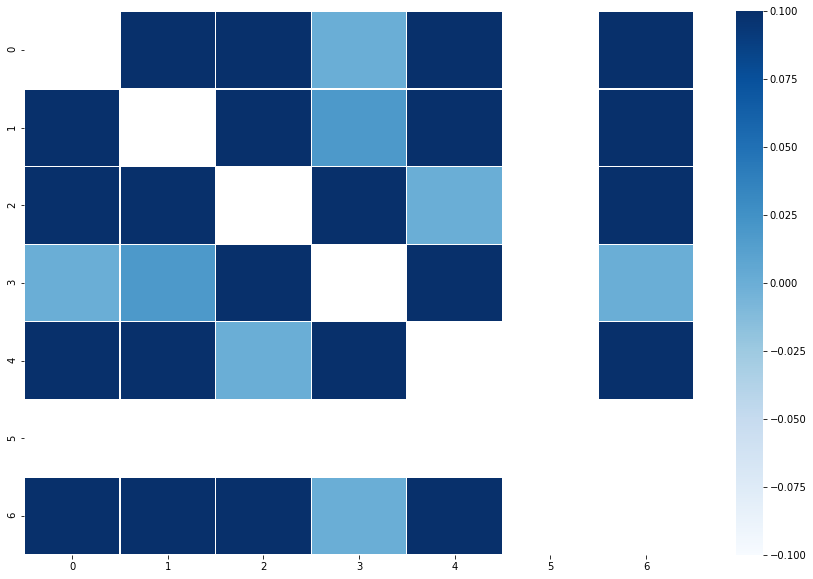

In [124]:
X_mrmr_base_noise = np.concatenate((X_mrmr_base, np.asarray(noise_col_3).reshape(-1,1)), axis=1)
print(X_mrmr_base_noise)
fig_num = 2
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_noise, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 5)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_noise, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_noise, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'

### 5.2.3.1 Save MRMR Base + Noise Dataset

In [125]:
mrmr_base_noise = np.concatenate((X_mrmr_base_noise,y_mrmr_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/mrmr_base_noise_simulated_data.csv",mrmr_base_noise , delimiter=",")

### 5.2.4 Base Dataset + Redundant + Noise

/opt/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


Selected Features by MRMR:  [0, 1, 2, 4, 3]


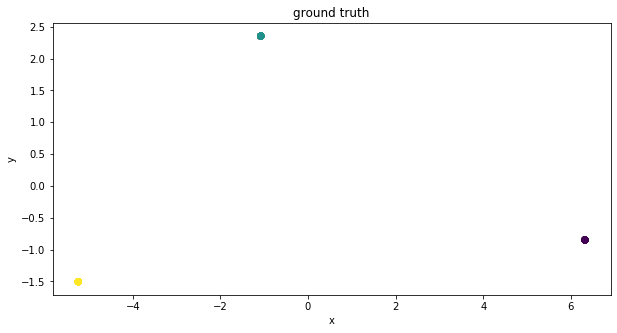

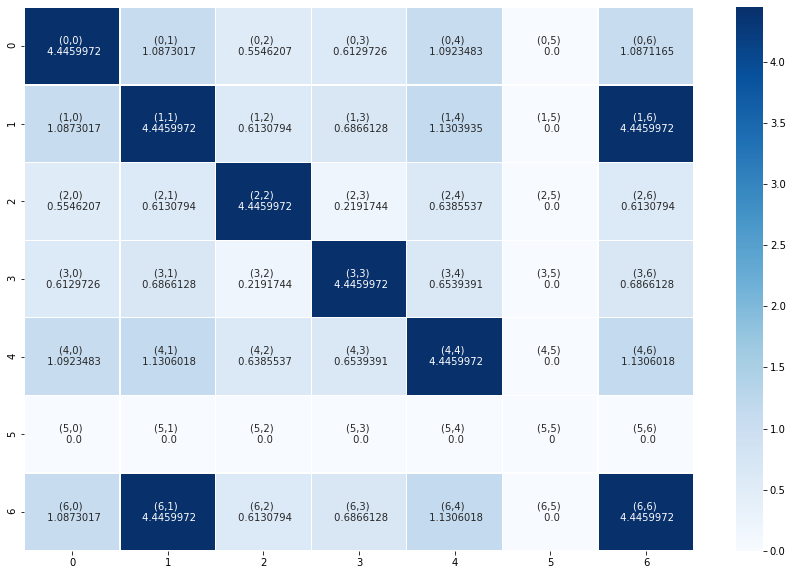

<Figure size 432x288 with 0 Axes>

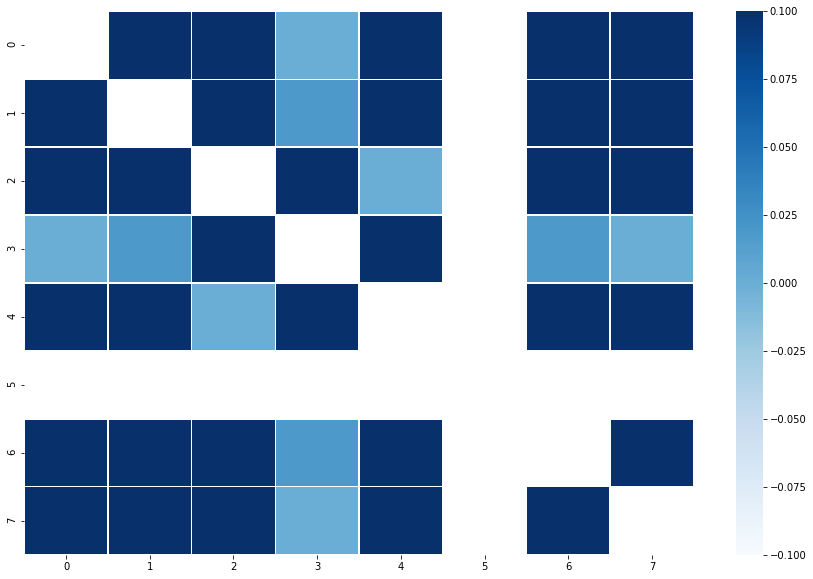

In [120]:
X_mrmr_base_noise = np.concatenate((X_mrmr_base, np.asarray(noise_col_3).reshape(-1,1)), axis=1)
X_mrmr_base_noise_redundant = np.concatenate((X_mrmr_base_noise, np.asarray(reduandant_col_1).reshape(-1,1)), axis=1)
# print(X_mrmr_base_noise)
fig_num = 2
mrmr_dummy_df = pd.DataFrame(np.concatenate((X_mrmr_base_noise_redundant, y_mrmr_base.reshape(-1, 1)), axis=1))
dummy_df_, dummy_labels, dummy_colum_indices,mim = mrmrSelection(mrmr_dummy_df, 5)
print("Selected Features by MRMR: ", dummy_colum_indices)

visualize_clusters(X_mrmr_base_noise_redundant, y_mrmr_base, fig_num)
arr, heat_map_labels = computeMIMatrix(X_mrmr_base_noise_redundant, fig_num)

fig,ax = plt.subplots(figsize=(15,10))
title = "Mutual Information between pairwise features"
sns.heatmap(mim, fmt="",cmap="Blues", linewidth=0.3, ax=ax)
path = 'mim_extracted_' + str(fig_num) + '.png'

### 5.2.4.1 Save MRMR Base + Redundant + Noise Dataset

In [126]:
mrmr_base_red_noise = np.concatenate((X_mrmr_base_noise_redundant,y_mrmr_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/mrmr_base_redundant_noise_simulated_data.csv",mrmr_base_red_noise , delimiter=",")

# 6. Classification Step
## 6.1 Classification Step Validation
### 6.1.1 Classify Dataset with Noise and Redundancy Added Before MRMR Step

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [191]:
n_total = 15
n_informative = 5
n_redundant = 5

X_before_mrmr, y_before_mrmr = make_classification(shuffle=False, 
                                                   n_samples=1000,
                                                   n_features=n_total,
                                                   n_redundant=n_redundant,
                                                   n_classes=4,
                                                   n_informative=n_informative,
                                                   n_clusters_per_class=2,
                                                   class_sep=5
                                                  )

X_train, X_test, y_train, y_test = train_test_split(X_before_mrmr, y_before_mrmr, test_size=0.2, random_state=42)

clf_svc = SVC()
clf_svc.fit(X_train, y_train)
pred_y_svc = clf_svc.predict(X_test)
acc_score = accuracy_score(y_test, pred_y_svc)
print("SVM Classifier Accuracy Score: ", acc_score)

clf_rf = RandomForestClassifier(random_state=0)
clf_rf.fit(X_train, y_train)
pred_y_rf = clf_rf.predict(X_test)
acc_score = accuracy_score(y_test, pred_y_rf)
print("RF Classifier Accuracy Score: ", acc_score)

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)
pred_y_lr = clf_lr.predict(X_test)
acc_score = accuracy_score(y_test, pred_y_lr)
print("LR Classifier Accuracy Score: ", acc_score)

SVM Classifier Accuracy Score:  0.995
RF Classifier Accuracy Score:  0.995
LR Classifier Accuracy Score:  0.995


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 6.1.2 Save Classification Dataset

In [192]:
classification_data = np.concatenate((X_before_mrmr,y_before_mrmr.reshape(-1,1)), axis=1)
np.savetxt("./datasets/classification_simulated_data.csv",classification_data , delimiter=",")

# 7. NeuroCombat Step Validation
## 7.1 NeuroCombat Step Implementation

In [6]:
class Combatstep():

    def __init__(self, debug_mode=False):
        """Apply fit_transform on the training data
            Arguments
            ---------
                debug_mode: boolean
                    If true, intermediate results will be printed for debugging purposes 
                    at the end of each function call.
        """
        self.model = CombatModel()
        self.debug_mode = debug_mode
        pass

    def fit_transform(self, X, y):
        """Apply fit_transform on the training data
            This function should be called upon the training data set. The combat model 
            is fitted and transformed. The data is adjusted/harmonized from the effects 
            of site data, sex data, age data and the labels. The discrete covariates includes
            the sex data and labels. The continuous covariates includes the normalized age
            data. 
            Arguments
            ---------
                X: numpy.ndarray
                    The training data with site, sex, age data attached.
                y: numpy.ndarray
                    The training data labels.
            Returns
            -------
                X_harmonized
                    The resulting harmonized data, ex cluding the site, sex, age data.
        """
        # extract site, sex, age data
        site = X[:, -1].reshape(-1, 1)
        sex = X[:, -2].reshape(-1, 1)
        age = X[:, -3].reshape(-1, 1)

        # exclude site, sex, age from from the data for harmonization
        X_raw = X[:, :-3]

        # reshape y array for concatenation
        y = y.reshape(-1, 1)

        # discrete_covariates: sex and y
        discrete_covariates = sex

        # continuous_covariates: age
        continuous_covariates = age

        # apply fit_transform on X
        X_harmonized = self.model.fit_transform(X_raw,
                                                site,
                                                discrete_covariates,
                                                continuous_covariates
                                                )

        # attach back the age and sex data to the X_harmonized
        age_sex_data = np.concatenate((age, sex), axis=1)

        X_harmonized = np.concatenate((X_harmonized, age_sex_data), axis=1)

        # print all the computed matrxi if debug mode is enabled
        if self.debug_mode == True:
            print("=" * 50 + " combat step fit_transform" + "=" * 50)
            print("X_init", X)
            print("X_raw", X_raw)
#             print("discrete_covariates", discrete_covariates)
#             print("continuous_covariates", continuous_covariates)
            print("X_harmonized.shape", X_harmonized.shape)
            print("age_sex_data", age_sex_data)
            print("X_harmonized", X_harmonized)

        return X_harmonized

    def transform(self, X, y):
        """Apply transformation on the testing data based on the fitted combat model.
            This function should be called upon the testing data set. The combat model has 
            already been fitted using the training data and the testing data is transformed
            accordingly. The data is adjusted/harmonized from the effects of site data, sex 
            data, age data and the labels. The discrete covariates includes the sex data 
            and labels. The continuous covariates includes the normalized age
            data. 
            Arguments
            ---------
                X: numpy.ndarray
                    The testing data with site, sex, age data attached.
                y: numpy.ndarray
                    The testing data labels.
            Returns
            -------
                X_harmonized
                    The resulting harmonized data, excluding the site, sex, age data.
        """
        # extract site, sex, age data
        site = X[:, -1].reshape(-1, 1)
        sex = X[:, -2].reshape(-1, 1)
        age = X[:, -3].reshape(-1, 1)
        # exclude site, sex, age from from the data for harmonization
        X_raw = X[:, :-3]

        # reshape y array for concatenation
        y = y.reshape(-1, 1)

        # discrete_covariates: sex and y
        discrete_covariates = sex

        # continuous_covariates: age
        continuous_covariates = age

        # apply fit_transform on X
        X_harmonized = self.model.transform(X_raw,
                                            site,
                                            discrete_covariates,
                                            continuous_covariates
                                            )
        # attach back the age and sex data to the X_harmonized
        age_sex_data = np.concatenate((age, sex), axis=1)

        X_harmonized = np.concatenate((X_harmonized, age_sex_data), axis=1)

        # print all the computed matrxi if debug mode is enabled
        if self.debug_mode == True:
            print("=" * 50 + " combat step transform" + "=" * 50)
            print("X_init", X)
            print("X_raw", X_raw)
            print("discrete_covariates", np.reshape(
                discrete_covariates, (1, -1)))
            print("continuous_covariates", np.reshape(
                continuous_covariates, (1, -1)))
            print("X_harmonized.shape", X_harmonized.shape)
            print("X_harmonized", X_harmonized)

        return X_harmonized

## 7.2 NeuroCombat Step Validation
### 7.2.1 Generate Simulated Dataset

In [7]:
label_list = [1,2,3]
n_samples_labels = [6,6,6]
inform_mean_list = [[10,10,10,10],[20,20,20,20],[30,30,30,30]]    #,[2,1,4,2]] # ,[4,5,6,7]
inform_std_list = [0.01, 0.01, 0.01, 0.01]
n_noise = [0, 0.000001, (0,100)]
X_base, y_base = generate_dummy_dataset(label_list, n_samples_labels, inform_mean_list,inform_std_list)
print("X_base:\n", X_base)
print("y_base:\n", y_base)

sites = np.asarray([1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2]).reshape(-1,1)
ages = np.asarray([95,91,91,91,91,91,91,91,91,91,95,95,95,95,95,95,95,95]).reshape(-1,1)
sex = np.asarray([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]).reshape(-1,1)

site_age_sex = np.concatenate((sites, ages, sex),axis=1)
print("site_age_sex:\n", site_age_sex.T)

X_base:
 [[ 9.99156855 10.00407757  9.99552745 10.02925022]
 [10.00229935  9.99871738  9.98775718 10.01968949]
 [10.01574236 10.00249486 10.002112   10.00150121]
 [10.00177079  9.99455309 10.00359975 10.0028099 ]
 [10.00919912 10.03041477 10.01217055  9.99447394]
 [ 9.9958422   9.99032668  9.99706043 10.0101483 ]
 [20.01363386 19.98972568 20.01279102 19.99711147]
 [19.99125243 20.0044679  19.99516334 20.00236089]
 [20.00249274 20.01239395 19.99601777 19.99488833]
 [19.99996621 20.00867447 19.99494668 19.99606936]
 [20.01865842 20.01139165 19.99164092 20.01431704]
 [19.98838107 19.99968315 19.99861661 19.99269135]
 [30.01040215 30.00184667 29.99591257 29.99243865]
 [30.01483417 29.9960827  29.97131836 30.01162306]
 [29.99146549 29.99363857 30.00727554 29.9926624 ]
 [29.9902882  29.99147428 30.00287149 30.00910009]
 [30.00341813 30.01136758 29.99074759 30.00353433]
 [29.98820369 30.00341904 29.99081669 30.00076274]]
y_base:
 [1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3]
site_age_sex:
 [[ 1  1  1

In [30]:
X_base = np.asarray([[ 2  , 9.5 , 10 ,  10],
                     [ 1  , 9.5 , 10 ,  10],
                     [ 1  , 9.5 , 10 ,  10],
                     [ 1  , 9.5 , 10 ,  10],
                     [ 1  , 9.5 , 10 ,  10],
                     [ 2  , 9.5 , 10 ,  10],
                     [ 2  , 9.5 , 10 ,  10],
                     [ 2  , 9.5 , 10 ,  10],
                     [ 2  , 9.5 , 10 ,  10],
                     [ 2  , 9.5 , 10 ,  10]])

############################# site ####################################

sites = np.asarray([2,2,1,1,1,1,1,1,1,1]).reshape(-1,1)
# sites = np.asarray([1,1,1,1,1,1,1,1,1,1]).reshape(-1,1)

############################# age #####################################

# ages = np.asarray([20,10,10,10,10,10,10,10,10,10]).reshape(-1,1)
ages = np.asarray([0.1,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1]).reshape(-1,1)

############################# sex #####################################

sex = np.asarray([1,1,1,1,1,1,1,1,1,1]).reshape(-1,1)

site_age_sex = np.concatenate((sites, ages, sex),axis=1)

print(np.concatenate((X_base, site_age_sex),axis=1))



[[ 2.   9.5 10.  10.   2.   0.1  1. ]
 [ 1.   9.5 10.  10.   2.   0.1  1. ]
 [ 1.   9.5 10.  10.   1.   0.1  1. ]
 [ 1.   9.5 10.  10.   1.   0.1  1. ]
 [ 1.   9.5 10.  10.   1.   0.1  1. ]
 [ 2.   9.5 10.  10.   1.   0.2  1. ]
 [ 2.   9.5 10.  10.   1.   0.1  1. ]
 [ 2.   9.5 10.  10.   1.   0.1  1. ]
 [ 2.   9.5 10.  10.   1.   0.1  1. ]
 [ 2.   9.5 10.  10.   1.   0.1  1. ]]


### 7.2.2 Base Dataset

In [31]:
# Creating model
model = CombatModel()
# Fitting the model and transforming the training set
X_train_harmonized = model.fit_transform(X_base, sites, sex, ages) # , sex, ages
# X_train_harmonized = model.fit_transform(X_base,sites,sex)
print("Harmonized: \n", X_train_harmonized)

# mean along the axis = 1  
print("mean of base data: \n", np.mean(X_base, axis = 0)) 
print("mean of base data, 0 - 4 : \n", np.mean(X_base[:5], axis = 0)) 
print("mean of base data, 5 - 9 : \n", np.mean(X_base[5:], axis = 0)) 
# mean along the axis = 1  
print("mean of harmonized data: \n", np.mean(X_train_harmonized, axis = 0))
print("mean of harmonized data: \n", np.mean(X_train_harmonized[0:5], axis = 0))
print("mean of harmonized data: \n", np.mean(X_train_harmonized[5:10], axis = 0))
# print("mean of harmonized data, 0 - 9 : \n", np.mean(X_train_harmonized, axis = 0))

Harmonized: 
 [[ 2.22645734  9.5        10.         10.        ]
 [ 1.13633313  9.5        10.         10.        ]
 [ 1.05095175  9.5        10.         10.        ]
 [ 1.05095175  9.5        10.         10.        ]
 [ 1.05095175  9.5        10.         10.        ]
 [ 2.10930925  9.5        10.         10.        ]
 [ 2.15307737  9.5        10.         10.        ]
 [ 2.15307737  9.5        10.         10.        ]
 [ 2.15307737  9.5        10.         10.        ]
 [ 2.15307737  9.5        10.         10.        ]]
mean of base data: 
 [ 1.6  9.5 10.  10. ]
mean of base data, 0 - 4 : 
 [ 1.2  9.5 10.  10. ]
mean of base data, 5 - 9 : 
 [ 2.   9.5 10.  10. ]
mean of harmonized data: 
 [ 1.72372644  9.5        10.         10.        ]
mean of harmonized data: 
 [ 1.30312914  9.5        10.         10.        ]
mean of harmonized data: 
 [ 2.14432375  9.5        10.         10.        ]


/opt/anaconda3/lib/python3.7/site-packages/neurocombat_sklearn/neurocombat_sklearn.py:348: RuntimeWarning: divide by zero encountered in true_divide
  (abs(delta_hat_new - delta_hat_old) / delta_hat_old).max())


In [125]:
version = 1
combined_combat_raw_data = np.concatenate((X_base,site_age_sex), axis=1)
df_base = pd.DataFrame(combined_combat_raw_data, index=None, columns=['feature1','feature2','feature3','feature4','site','age','sex'])
df_harmonized = pd.DataFrame(X_train_harmonized, index=None, columns=['feature1','feature2','feature3','feature4'])
df_base.to_csv(('./datasets/combat/base_{}.csv').format(version),index=None)
df_harmonized.to_csv(('./datasets/combat/harmonized_{}.csv').format(version),index=None)

In [32]:
import neuroCombat as combat
harmonized = combat.neuroCombat(X_base.T, pd.DataFrame(site_age_sex),0 ,2 ,1)
print(harmonized.T)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[[ 2.30197442  9.5        10.         10.        ]
 [ 1.24883013  9.5        10.         10.        ]
 [ 1.04661022  9.5        10.         10.        ]
 [ 1.04661022  9.5        10.         10.        ]
 [ 1.04661022  9.5        10.         10.        ]
 [ 2.09867965  9.5        10.         10.        ]
 [ 2.13773173  9.5        10.         10.        ]
 [ 2.13773173  9.5        10.         10.        ]
 [ 2.13773173  9.5        10.         10.        ]
 [ 2.13773173  9.5        10.         10.        ]]


/opt/anaconda3/lib/python3.7/site-packages/neuroCombat/neuroCombat.py:299: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


### 7.2.3 Base Dataset + Outlier

In [146]:
X_outlier = np.copy(X_base)
X_outlier[0][1] = 100
print("Base Dataset + Outlier\n", X_outlier)

# Creating model
model = CombatModel()

# Fitting the model and transforming the training set
X_train_harmonized = model.fit_transform(X_outlier,sites,sex,ages)
print("Harmonized: \n", X_train_harmonized)

Base Dataset + Outlier
 [[  9.1 100.   10.   10. ]
 [  9.2   9.5  10.   10. ]
 [  9.1   9.5  10.   10. ]
 [  9.2   9.5  10.   10. ]
 [  9.1   9.5  10.   10. ]
 [  9.2   9.5  10.   10. ]
 [  2.1   9.5  10.   10.5]
 [  2.2   9.5  10.   10.5]
 [  2.1   9.5  10.   10.5]
 [  2.2   9.5  10.   10.5]
 [  2.1   9.5  10.   10.5]
 [  2.2   9.5  10.   10.5]
 [  5.1   9.5  10.   10. ]
 [  5.2   9.5  10.   10. ]
 [  5.1   9.5  10.   10. ]
 [  5.2   9.5  10.   11. ]
 [  5.1   9.5  10.   10. ]
 [  5.2   9.5  10.   10. ]]
Harmonized: 
 [[ 25.73275412 219.76653582  36.75370463  37.2150811 ]
 [ 26.3229383   42.58856095  36.75370463  37.2150811 ]
 [ 25.73275412  42.58856095  36.75370463  37.2150811 ]
 [ 26.3229383   42.58856095  36.75370463  37.2150811 ]
 [ 25.73275412  42.58856095  36.75370463  37.2150811 ]
 [ 26.3229383   42.58856095  36.75370463  37.2150811 ]
 [ -0.53757584  62.01787443  43.18792509  44.16724018]
 [ 47.1346033   62.01787443  43.18792509  44.16724018]
 [ -0.53757584  62.01787443  43.187

/opt/anaconda3/lib/python3.7/site-packages/neurocombat_sklearn/neurocombat_sklearn.py:348: RuntimeWarning: divide by zero encountered in true_divide
  (abs(delta_hat_new - delta_hat_old) / delta_hat_old).max())


## 7.3 Save Simulated Dataset

In [176]:
combat_base = np.concatenate((np.concatenate((X_base, site_age_sex), axis=1),y_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/combat_base_simulated_data.csv",combat_base , delimiter=",")

combat_outlier = np.concatenate((np.concatenate((X_outlier, site_age_sex), axis=1),y_base.reshape(-1,1)), axis=1)
np.savetxt("./datasets/combat_outlier_simulated_data.csv", combat_outlier , delimiter=",")

# 8. Integrated Validation
## 8.1 Import all pipeline steps

In [7]:
def t_test(X, y):
    
    def separate(X, y):
        # Y is the classes (1=stable, 2=progressor)
        P_X, S_X = [], []
        for i in range(X.shape[0]):
            if  y[i] == 0:
                S_X.append(X[i])
            elif y[i] == 1:
                P_X.append(X[i])
        return np.asarray(P_X), np.asarray(S_X)

    def t_test(P, S, y):
        t_vals = []
        for i in range(P.shape[1]):
            t_score, p_val = stats.ttest_ind(P[:,i], S[:,i])
            tuple_ = (abs(t_score), abs(p_val))
            t_vals.append((tuple_, i))
        return t_vals

    def select(X, y, t_vals, percentage=.75):
        total_nfeatures = X.shape[1]
        filtered_nfeatures = math.ceil(total_nfeatures*percentage)
#         print("total_nfeatures: ",total_nfeatures)
#         print("filtered_nfeatures", filtered_nfeatures)
        sorted_t_val = sorted(t_vals, key=lambda tup: tup[0][0], reverse=True)
#         print(sorted_t_val)
        selected_indices = [i[1] for i in sorted_t_val[:filtered_nfeatures]]
        sorted_selected_indices = sorted(selected_indices)
        X_reduced = X[:,sorted_selected_indices]
        return X_reduced, sorted_selected_indices
    
    P_X, S_X = separate(X, y)
    t_vals = t_test(P_X, S_X, y)
    X_reduced, selected_indices = select(X, y, t_vals)
    return X_reduced, selected_indices

from snf import compute

class Clustering():

    def __init__(self, debug_mode=False):
        """Apply fit_transform on the training data

            Arguments
            ---------
                debug_mode: boolean
                    If true, intermediate results will be printed for debugging purposes 
                    at the end of each function call.
        """
        self.debug_mode = debug_mode
        pass

    # setter for number of subclusters for P
    def setNumP(self, numP):
        self.numP = numP

    # setter for number of subclusters for S
    def setNumS(self, numS):
        self.numS = numS

    # Step1. Separate out P and S
    def separate(self, X, y):
        """Separate out the progressor and stable instances to be used for clustering later. 

            As the data in is reindexed by the stratifiedKfold. It is important for us
            to save the indexes of the rows before we separate them out and do clustering 
            accordingly. In this function, while the data is splitted into separate lists 
            by class, the original index for each row is saved. After the clustering is done, 
            we will reindex our combined data set according to the saved indexes.

            Arguments
            ---------
                X: numpy.ndarray
                    The combined data
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                P_X: list
                    Progressor data
                P_y: list
                    Progressor data labels
                S_X: list
                    Stable data
                S_y: list
                    Stable data labels     
        """

        # initialize empty lists to store index of P&S instances in the
        # original data
        index_P, index_S = [], []

        # initialize lists to store the separated P and S instances
        P_X, P_y, S_X, S_y = [], [], [], []
        # store P and S instances separately and keep track of the indexes in
        # the original data

        for i in range(0, y.shape[0]):
            if y[i] == 1:
                S_X.append(X[i])
                S_y.append(y[i])
                index_S.append(i)
            else:
                P_X.append(X[i])
                P_y.append(y[i])
                index_P.append(i)

        # store the indexes as a global attribute for the clasds
        self.index_P = index_P
        self.index_S = index_S

        # print all the computed matrxi if debug mode is enabled
        if self.debug_mode == True:
            print("index_P", self.index_P)
            print("index_S", self.index_S)

#         print("P_X separate", P_X)
        return np.asarray(P_X), np.asarray(P_y), np.asarray(S_X), np.asarray(S_y)

    def clusteringP(self, P_X):
        """Apply Spectral Clustering on Progressor data.

            SpectralClustering is performed on P class instances. The number of clusters 
            is specified by the global attribute num_P. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                P_X: list
                    The progressor data.
            Returns
            -------
                P_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """
        affinity_networks = compute.make_affinity(P_X, metric='euclidean', K=self.numP, mu=0.5)
        
        clusteringP = SpectralClustering(affinity='precomputed',
            n_clusters=self.numP, random_state=0).fit(affinity_networks)
        
        labels = clusteringP.labels_.reshape(-1, 1)
        P_X = np.asarray(P_X)
        P_X_clustered = np.concatenate((P_X, labels), axis=1)

        if self.debug_mode == True:
            print("P labels", np.reshape(labels, (1, -1)))
            print("P_X_clustered", P_X_clustered)

        return P_X_clustered

    def clusteringS(self, S_X):
        """Apply Spectral Clustering on Stable data.

            SpectralClustering is performed on the S class instances. The number of clusters 
            is specified by the global attribute num_S. At the end of the step, the original
            labels will be discarded and the new labels will be attached to the end of the data
            for convenience. The assign_labels for the SpectralClustering is "discrete" and 
            random_state is set to 0. 

            Arguments
            ---------
                S_X: list
                    The progressor data.
            Returns
            -------
                S_X_clustered: numpy.ndarray
                    The combined clustered progressor data with new labels attached to the end.
        """

        affinity_networks = compute.make_affinity(S_X, metric='euclidean', K=self.numS, mu=0.5)
        
        clusteringS = SpectralClustering(affinity='precomputed',
            n_clusters=self.numS, random_state=0).fit(affinity_networks)

        labels = clusteringS.labels_
        labels = labels + self.numP
        S_X = np.asarray(S_X)
        labels = labels.reshape(-1, 1)
        S_X_clustered = np.concatenate((S_X, labels), axis=1)

        if self.debug_mode == True:
            print("S labels", np.reshape(labels, (1, -1)))
            print("S_X_clustered", S_X_clustered)

        return S_X_clustered

    def transform(self, X, y):
        """Apply Spectral Clustering on stable data and progressor data. 
            Step 1. Separate data out into P and S classes. Save the original data index as 
            the data rows will be reindexed for clustering. 
            Step 2. Perform clustering for P class based on num_P. Attach the new labels.
            Step 3. Perform clustering for S class based on num_S. Attach the new labels. 
            Step 4. Combine the newly clustered P class data and S class data. Reindex the 
            data rows according to the saved indexes. 
            Arguments
            ---------
                X: numpy.ndarray
                    The combined data of both P and S instances.
                y: numpy.ndarray
                    The combined data labels.
            Returns
            -------
                X_output: numpy.ndarray
                    The combined data with newly clustered labels attached.
        """

        P_X, P_y, S_X, S_y = self.separate(X, y)

        P_X_clustered = self.clusteringP(P_X)
        S_X_clustered = self.clusteringS(S_X)

        P_X_clustered_with_index = np.concatenate(
            (P_X_clustered, (np.array(self.index_P)).reshape(-1, 1)), axis=1)
        S_X_clustered_with_index = np.concatenate(
            (S_X_clustered, (np.array(self.index_S)).reshape(-1, 1)), axis=1)

        X_combined_with_index = np.concatenate(
            (P_X_clustered_with_index, S_X_clustered_with_index), axis=0)

        X_sorted = X_combined_with_index[
            np.argsort(X_combined_with_index[:, -1])]
        new_labels = X_sorted[:,-2]
        X_output = X_sorted[:, :-2]

        if self.debug_mode == True:
            print("P_X_clustered_with_index", P_X_clustered_with_index)
            print("S_X_clustered_with_index", S_X_clustered_with_index)
            print("X_sorted", X_sorted)
            print("X_output", X_output)
            print("X_output.labels", X_output[:, -1])

        return X_output, new_labels
    
    
def mrmrSelection(dataframe, nFeature):
    """Perform MRMR on the passed in data. 

        This function performs feature selection based on the mRMRe feature selection. 
        It utilizes the mRMRe package originally written in R. A python wrapper for R is
        used here. The eMRMRe returns a list of the selected column indices given the 
        number of features to be selected. 

        Arguments
        ---------
            dataframe: pandas.DataFrame
                The dataframe containing clustered data. 
        Returns
        -------
            df_: pandas.DataFrame
                The dataframe with only selected columns.
            labels: pandas.DataFrame
                The dataframe of only the labels
            colum_indices: list
                The list of indices of the selected columns
    """ 
    base = importr('base')
    mr = importr('mRMRe')
    pandas2ri.activate()
    # Convert the data into R format
    with localconverter(ro.default_converter + pandas2ri.converter):
        rdataframe = ro.conversion.py2rpy(dataframe)
    mrmrData = mr.mRMR_data(data = (rdataframe))
    solutionCount = 1
    selectionEnsemble = mr.mRMR_ensemble("mRMRe.Data",data = mrmrData, target_indices = (dataframe.shape[1]),
          feature_count = nFeature, solution_count = solutionCount)
    colum_indices =(mr.solutions(selectionEnsemble)[0]-1)
    mutual_information_matrix = mr.mim(mrmrData)
    df_ = pd.DataFrame()
    for i,v in enumerate(colum_indices):
        df_[i] = dataframe[v[0]]
    labels = dataframe.iloc[:,-1]
    colum_indices = list(np.reshape(colum_indices,(1,-1))[0])
    return df_, labels, colum_indices, mutual_information_matrix


### 8.2 Generate a set of simulated data
- n_samples=302
- n_features=75 
- n_informative=50 
- n_redundant=0 
- n_classes=2 
- n_clusters_per_class=3 
- weights=None 
- class_sep=15.0 
- hypercube=True
- shuffle=False
- random_state=None

In [29]:
class_sep = 2

In [30]:


X,y = make_classification(n_samples=302, 
                          n_features=75, 
                          n_informative=50, 
                          n_redundant=0, 
                          n_classes=2, 
                          n_clusters_per_class=3, 
                          weights=None, 
                          class_sep=class_sep, 
                          hypercube=True,
                          shuffle=False, 
                          random_state=None)

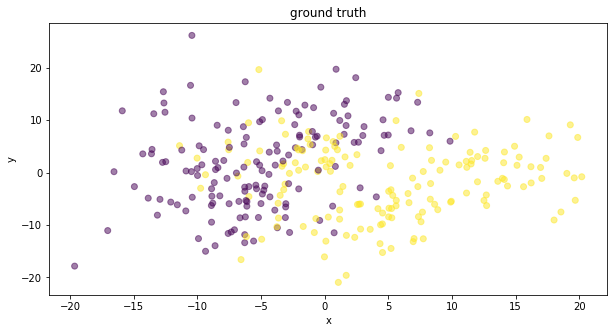

In [31]:
visualize_clusters(X, y, 1)

### 6.3 Save the generated dataset to disk

In [32]:
root_path = ('./datasets/integrated/{}').format(class_sep)

try:
    os.mkdir(root_path)
except OSError:
    print ("Creation of the directory %s failed" % root_path)
else:
    print ("Successfully created the directory %s " % root_path)

Successfully created the directory ./datasets/integrated/2 


In [33]:
filename_x = root_path+('/X_{}.p').format(class_sep)
filename_y = root_path+('/y_{}.p').format(class_sep)
with open(filename_x, 'wb') as filehandler_x:
    pickle.dump(X, filehandler_x)
with open(filename_y, 'wb') as filehandler_y:
    pickle.dump(y, filehandler_y)

In [34]:
filename_x = root_path+('/X_{}.p').format(class_sep)
filename_y = root_path+('/y_{}.p').format(class_sep)
with open(filename_y, 'rb') as filehandler: 
    y_integrated = pickle.load(filehandler)
    print(y_integrated)
    
with open(filename_x, 'rb') as filehandler: 
    X_integrated = pickle.load(filehandler)
    print(X_integrated)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[[ 2.50202148  1.0739187  -3.1935008  ...  0.23992469 -1.06599353
   0.57710123]
 [-2.69860737  7.14642437  5.04088835 ...  1.80414309 -0.82092289
  -0.08909023]
 [-0.82434821 -3.83584872  4.568725   ...  0.43781377 -1.3300474
  -0.71005129]
 ...
 [-7.63324837 -5.00503364 -1.01143324 ...  0.05715436 -0.66704528
  -0.94838574]
 [-7.53094166 -8.50742482  1.84943953 ...  0.31593151  0.4

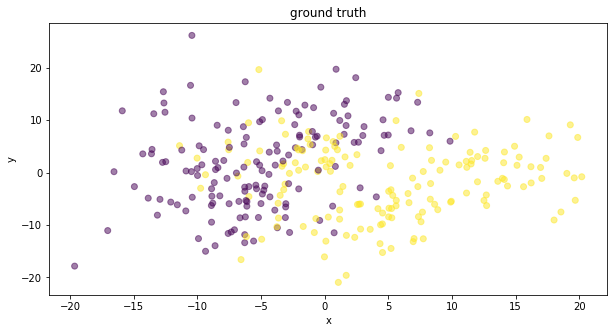

In [35]:
visualize_clusters(X_integrated, y_integrated, 1)

In [36]:
p_index = [index for index,i in enumerate(y) if i==0]
s_index = [index for index,i in enumerate(y) if i==1]
print(p_index)
print(s_index)
print(y_integrated[p_index])
print(y_integrated[s_index])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
[32, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171

In [37]:
Xp = X_integrated[p_index]
Xs = X_integrated[s_index]
yp = y_integrated[p_index]
ys = y_integrated[s_index]

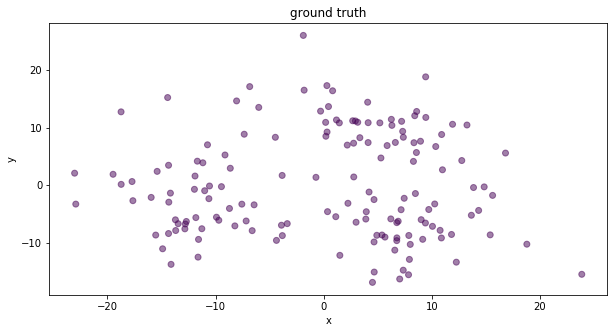

In [38]:
visualize_clusters(Xp, yp, 1)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0]


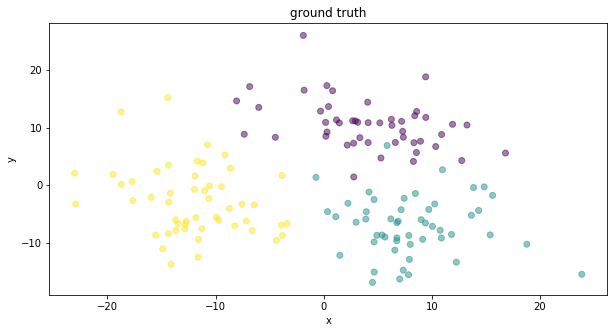

In [39]:
kmeans_p = KMeans(n_clusters=3, random_state=0).fit(Xp)
print(kmeans_p.labels_)
visualize_clusters(Xp, kmeans_p.labels_, 1)
p_sublabel = kmeans_p.labels_

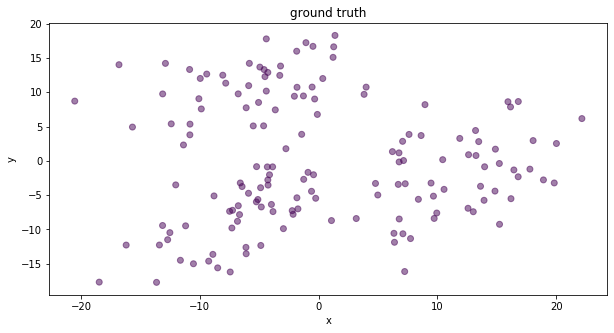

In [40]:
visualize_clusters(Xs, ys, 1)

[1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
[4 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4]


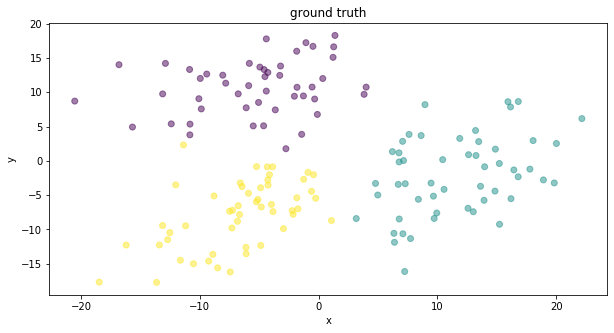

In [41]:
kmeans_s = KMeans(n_clusters=3, random_state=0).fit(Xs)
print(kmeans_s.labels_)
visualize_clusters(Xs, kmeans_s.labels_, 1)
s_sublabel = kmeans_s.labels_ + 3
print(s_sublabel)

In [42]:
X_concat = np.concatenate((Xp, Xs),axis=0)
y_concat = np.concatenate((yp, ys),axis=0)
y_concat = np.asarray([i+1 for i in y_concat])
sublabel_concat = np.concatenate((p_sublabel,s_sublabel),axis=0)
print(y_concat)
print(sublabel_concat)
informative=X_concat[:,0:25]
redundant=informative.copy()
for i in range(25):
    redundant[:,i] = redundant[:,i]*2
# print(informative)
# print(redundant)
print("X_concat.shape: ", X_concat.shape)
X_new = np.zeros((302,100))
X_new[:,0:50] = X_concat[:,0:50]
X_new[:,50:75] = redundant
X_new[:,75:100] = X_concat[:,50:75]
print("X_new.shape: ", X_new.shape)
print("X_new: ", X_new)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 4 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 

In [43]:
np.savetxt((root_path+("/X_{}_integrated.csv").format(class_sep)), X_concat, delimiter=",")
np.savetxt((root_path+("/y_{}_integrated.csv").format(class_sep)), y_concat, delimiter=",")
np.savetxt((root_path+("/subtype_labels_{}.csv").format(class_sep)), sublabel_concat, delimiter=",")

In [44]:
X_i = np.genfromtxt((root_path+("/X_{}_integrated.csv").format(class_sep)), delimiter=',')
print("X_integrated: \n", X_i)

X_integrated: 
 [[ 2.50202148  1.0739187  -3.1935008  ...  0.23992469 -1.06599353
   0.57710123]
 [-2.69860737  7.14642437  5.04088835 ...  1.80414309 -0.82092289
  -0.08909023]
 [-0.82434821 -3.83584872  4.568725   ...  0.43781377 -1.3300474
  -0.71005129]
 ...
 [-7.63324837 -5.00503364 -1.01143324 ...  0.05715436 -0.66704528
  -0.94838574]
 [-7.53094166 -8.50742482  1.84943953 ...  0.31593151  0.45423447
   1.39020904]
 [ 0.2596688   0.23992958 -6.75742379 ...  0.26727456 -2.07544305
   0.88313832]]


In [45]:
integrated_x_df = pd.DataFrame(X_i)
integrated_x_df

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,2.502021,1.073919,-3.193501,3.513326,-2.363234,-2.958585,-2.702493,0.563936,2.610844,1.021118,...,-1.169637,0.390957,-0.371616,-0.004692,0.035869,-1.161721,-0.145734,0.239925,-1.065994,0.577101
1,-2.698607,7.146424,5.040888,1.753926,-6.107821,6.234648,-2.538835,1.661548,3.261363,-1.521605,...,0.691202,0.443716,0.872944,-2.474004,0.020286,-1.703301,-0.651639,1.804143,-0.820923,-0.089090
2,-0.824348,-3.835849,4.568725,5.825481,-6.791309,-1.385102,-1.137831,-6.180559,1.295489,6.465268,...,1.372849,0.646285,-0.486754,0.826359,-1.040330,0.898406,-0.971670,0.437814,-1.330047,-0.710051
3,-8.332203,-7.232229,5.833542,7.762692,-3.774588,1.706778,4.768451,-7.285949,-4.545670,6.379357,...,-1.000097,-0.262487,-1.122763,1.677013,0.100651,0.621386,-1.307344,0.367103,0.017040,-0.881464
4,-4.795688,10.671869,-3.634479,2.508158,-6.568557,3.768352,4.976247,-8.062283,2.797455,0.886169,...,1.240628,0.064658,-0.835841,0.761234,1.096256,-0.710995,-0.411219,-0.411133,-0.123934,0.354551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,-1.189394,-0.266111,-0.179004,-3.964604,7.162353,-8.143425,4.754976,-3.038346,-2.072938,-7.078119,...,-0.216615,1.071666,-2.255178,-0.322580,0.991501,0.417657,1.975109,1.560995,0.255843,-1.098013
298,-0.435050,-4.331953,-1.404381,-3.879851,2.463574,-3.886843,-6.214492,2.674602,-1.185818,1.012731,...,-0.461698,0.068661,1.858399,1.407579,0.561061,-0.015776,1.200957,0.905378,-1.220840,0.981904
299,-7.633248,-5.005034,-1.011433,-1.843051,4.237165,-8.720708,1.555092,1.067152,-2.292284,0.646995,...,1.040305,-1.295907,-0.280714,0.326799,0.459353,-1.266124,-1.135332,0.057154,-0.667045,-0.948386
300,-7.530942,-8.507425,1.849440,-2.813232,4.725612,-2.957019,-4.805404,3.061160,-5.120419,2.289160,...,0.957461,-1.534867,-1.416957,0.364343,0.475766,-2.416895,0.158737,0.315932,0.454234,1.390209


In [46]:
y_i = np.genfromtxt((root_path+("/y_{}_integrated.csv").format(class_sep)), delimiter=',')
int_array = y_i.astype(int)
print("y_integrated: \n", int_array)

y_integrated: 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]


In [47]:
sub = np.genfromtxt((root_path+("/subtype_labels_{}.csv").format(class_sep)), delimiter=',')
int_array = sub.astype(int)
print("subtype labels: \n", int_array)

subtype labels: 
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 4 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]


In [48]:
outer_train_index_pickle = open(
        "./split/outer_train_index.pickle", "rb")
outer_train_indexes = pickle.load(outer_train_index_pickle)
for i in range(len(outer_train_indexes)):
    print(("Training data indexes for outer fold {}").format(i))
    print(outer_train_indexes[i])

FileNotFoundError: [Errno 2] No such file or directory: './split/outer_train_index.pickle'

In [204]:
outer_train_index_pickle = open(
        "./split/outer_test_index.pickle", "rb")
outer_train_indexes = pickle.load(outer_train_index_pickle)
for i in range(len(outer_train_indexes)):
    print(("Test data indexes for outer fold {}").format(i))
    print(outer_train_indexes[i])

Test data indexes for outer fold 0
[  6  10  11  13  16  20  21  27  42  47  50  62  64  67  71  75  81  87
  96  97  98 101 104 112 114 117 125 126 129 133 135 163 170 171 176 181
 182 184 185 190 201 206 210 214 224 236 237 238 239 242 249 258 261 268
 270 275 278 284 292 296 300]
Test data indexes for outer fold 1
[  5  19  22  28  30  31  32  36  38  48  52  59  61  70  74  78  83  84
  90  91 103 110 113 115 121 122 123 140 143 147 154 157 158 162 165 173
 178 179 192 194 195 220 222 229 230 232 235 240 244 246 247 262 265 269
 276 286 288 289 294 297 298]
Test data indexes for outer fold 2
[  0   3   8  24  25  29  35  44  45  46  53  54  55  58  69  79  82  85
  86 100 102 106 107 119 124 128 130 131 141 150 152 164 172 183 186 189
 193 197 198 200 202 205 207 208 211 213 225 226 241 245 252 256 257 263
 264 272 273 283 293 295]
Test data indexes for outer fold 3
[  1   4   7  12  15  17  18  34  37  49  51  56  57  65  68  72  73  76
  77  93 109 116 118 120 127 132 134 137 139